In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import tqdm as tqdm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv', encoding = 'cp949')
test = pd.read_csv('test.csv',encoding = 'cp949')
submission = pd.read_csv('sample_submission.csv', encoding = 'cp949')

In [3]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


- test에 엄청 많은 결측치가 포함되어있다.

In [6]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [7]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
train=train.rename(columns = {'전력사용량(kWh)': 'target'})

test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

Text(0.5, 1.0, 'boxenplot of target')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


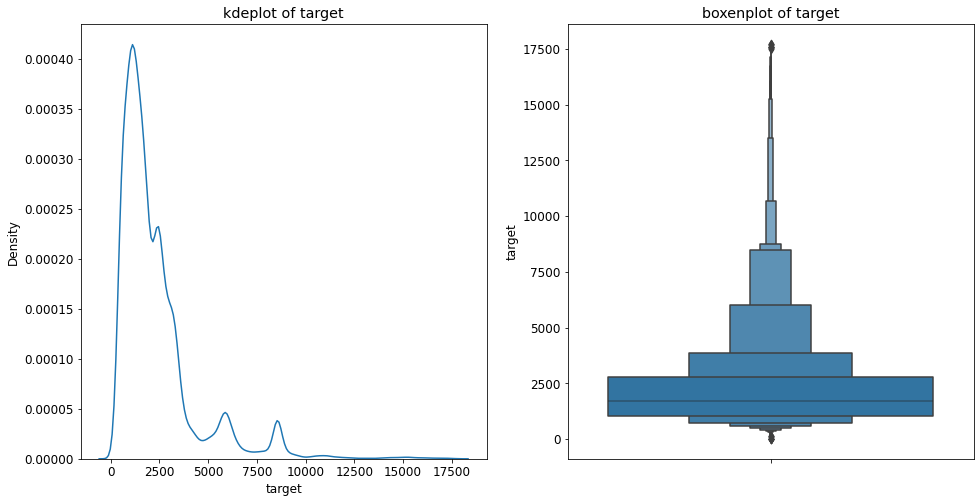

In [8]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'target', ax = ax[1])
ax[1].set_title('boxenplot of target')

- 이상치가 많은것으로 보여진다.

<AxesSubplot:>

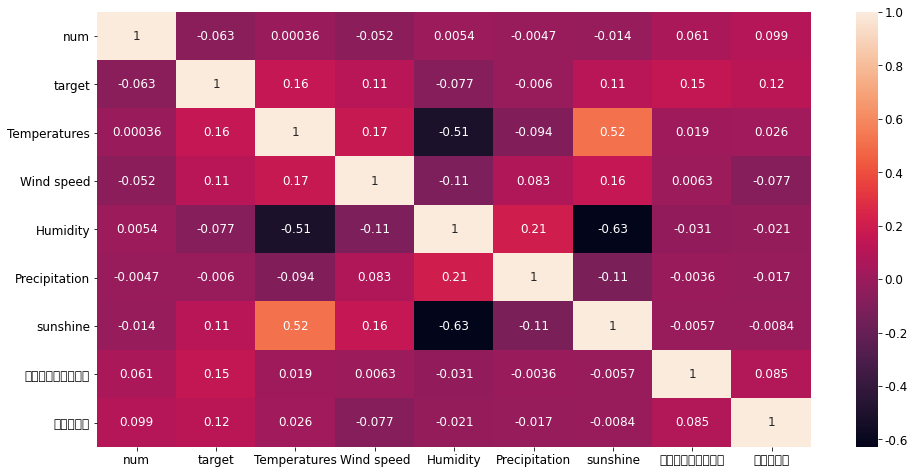

In [9]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm)':'Precipitation','일조(hr)':'sunshine'})

train_corr=train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

## num(한 건물을 나타낸다.)

In [10]:
train.num.unique()
# 60개의 건물이 있다는 것을 확인했다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

<AxesSubplot:xlabel='num', ylabel='target'>

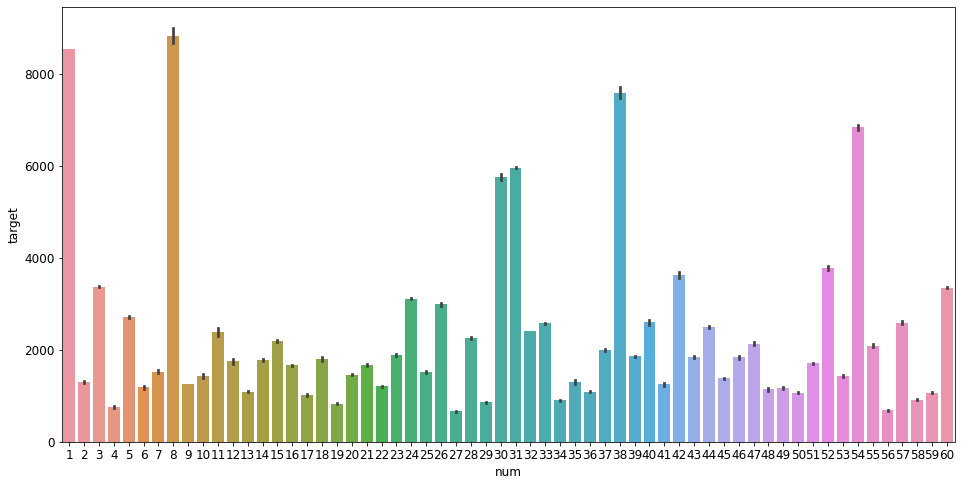

In [11]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'num', y = 'target')

- 각 건물마다 전기 사용량이 제각각 다른 것을 확인했다.

## date_time

In [12]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)

In [13]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekday'] = df['weekday'].apply(lambda x:1 if x >4 else 0)
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

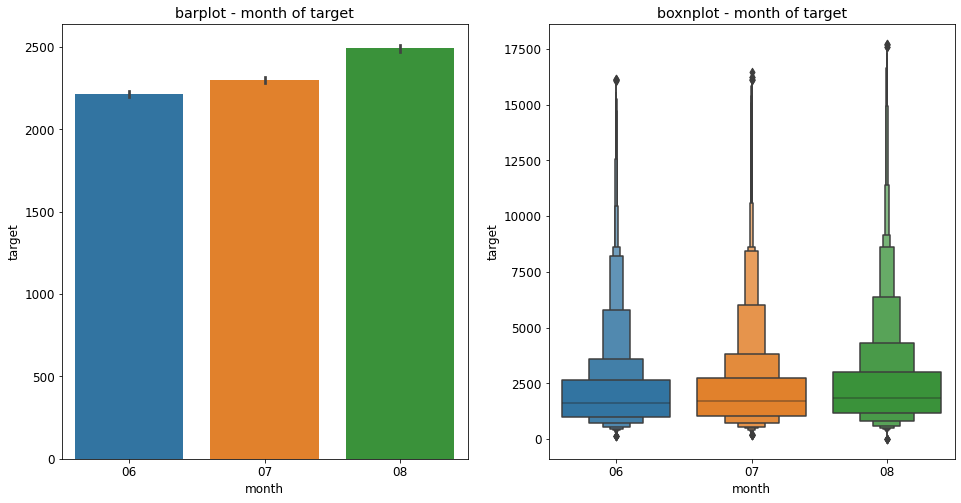

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

- 시간이 지날수록 더 많은 전력량을 사용하는 것을 알 수 있다.
- 우리는 test값이 8월달의 데이터만 가지고 있기 때문에 어떻게 분석해줄지는 확인해 봐야겠다.

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

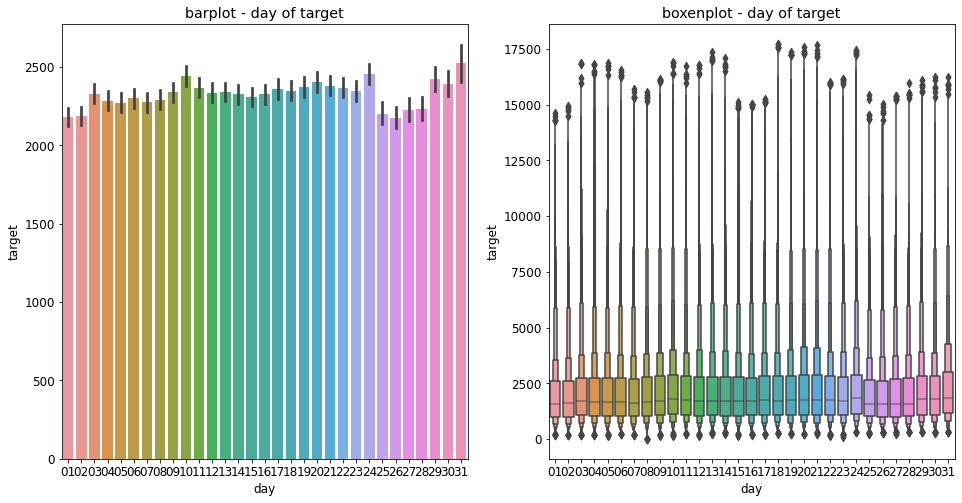

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

- 일별로 큰 차이가 있다고 말 할수는 없을 것 같다

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

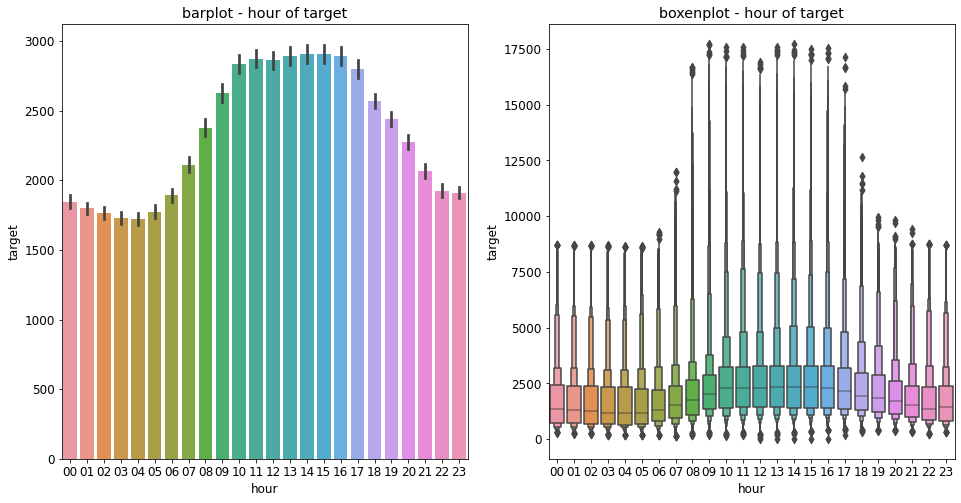

In [16]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

- 시간별로 확실한 차이가 있다고 말할 수 있다.
- 사람들이 활동하는 시간에 전력소모량이 가장 많은 것을 알 수 있다.

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

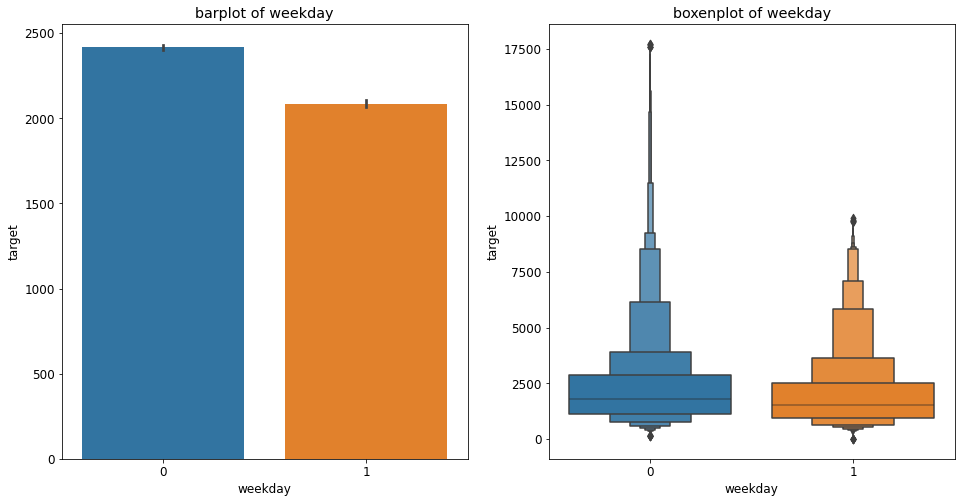

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

- 평일에 많은 전력량을 소모하는 것으로 나타낸다.

Text(0.5, 1.0, 'weekday month target')

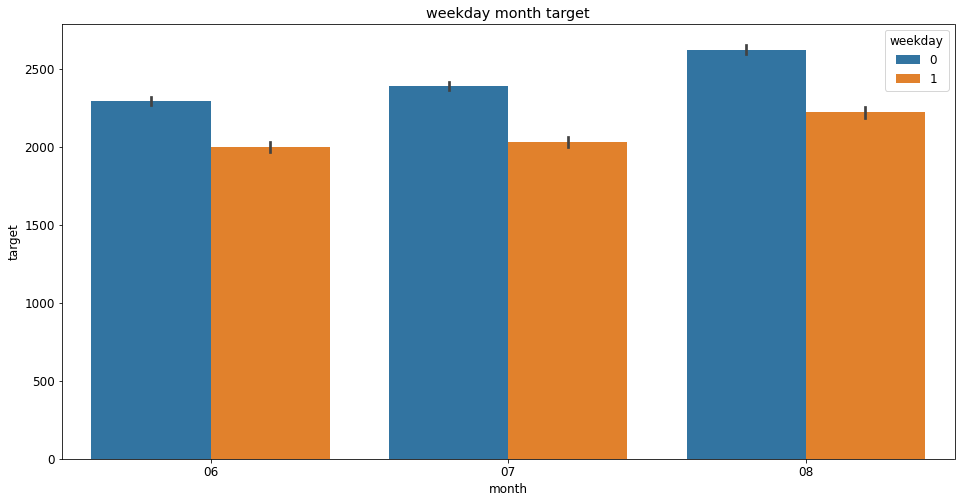

In [18]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

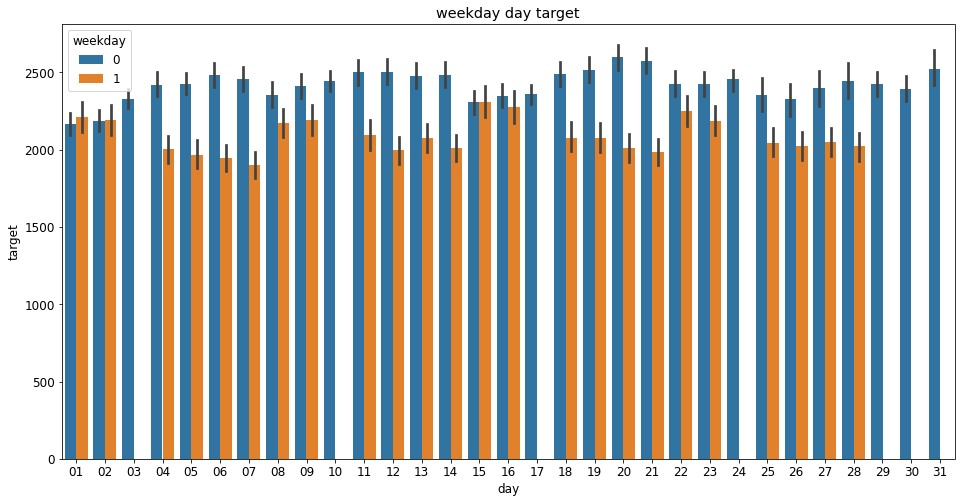

In [19]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

- 주말이 없는 날짜가 있기 때문에 표시가 안된 부분도 있다.

Text(0.5, 1.0, 'weekday hour target')

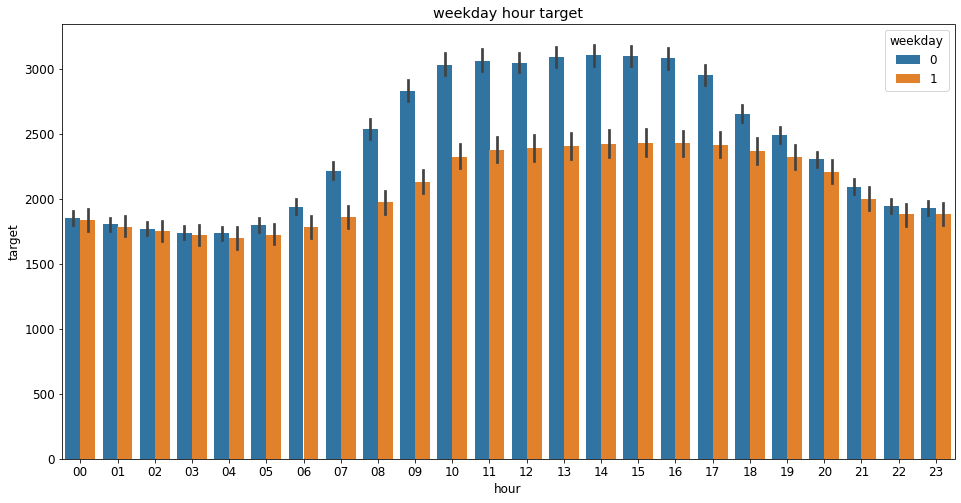

In [20]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

## 기온(Temperatures)

In [21]:
# min = 11.1, max = 36.3
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

<AxesSubplot:xlabel='Temperatures', ylabel='Density'>

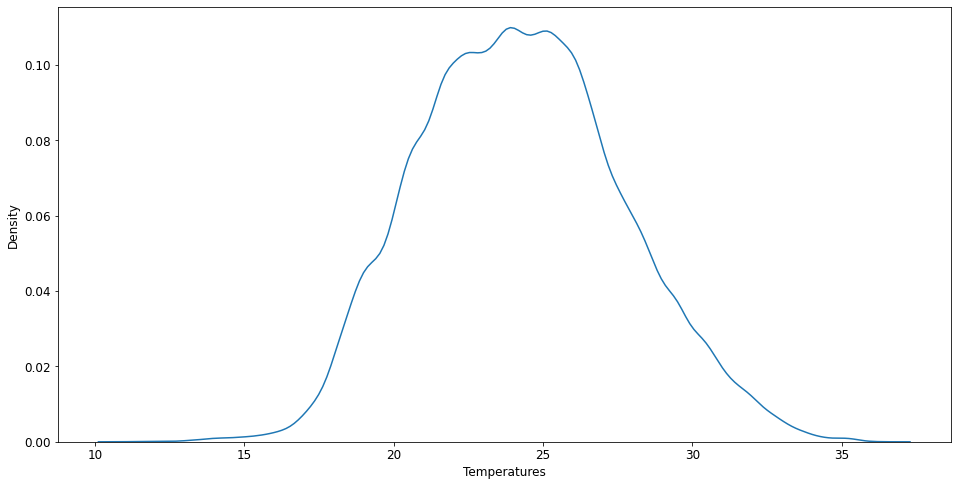

In [22]:
sns.kdeplot(data = train, x = 'Temperatures')

<AxesSubplot:xlabel='Temperatures', ylabel='target'>

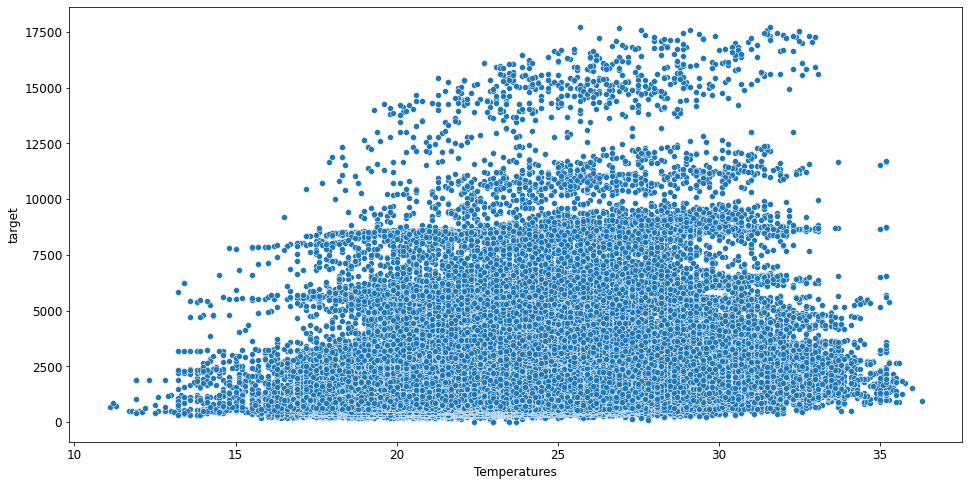

In [23]:
sns.scatterplot(data = train, x = 'Temperatures', y = 'target')

In [24]:
# 이 데이터는 온도에 따라 나눠주는 것이기 때문에 train의 데이터롤 그대로 가지고 와야한다.
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

In [25]:
train.loc[21.800000 >= train['Temperatures'], 'temperature_binning'] = 0
train.loc[(21.800000 < train['Temperatures']) & (train['Temperatures'] < 24.200000), 'temperature_binning'] = 1
train.loc[(24.200000 < train['Temperatures']) & (train['Temperatures'] < 26.500000), 'temperature_binning'] = 2
train.loc[(26.500000 < train['Temperatures']), 'temperature_binning'] = 3

test.loc[21.800000 >= test['Temperatures'], 'temperature_binning'] = 0
test.loc[(21.800000 < test['Temperatures']) & (test['Temperatures'] < 24.200000), 'temperature_binning'] = 1
test.loc[(24.200000 < test['Temperatures']) & (test['Temperatures'] < 26.500000), 'temperature_binning'] = 2
test.loc[(26.500000 < test['Temperatures']), 'temperature_binning'] = 3

Text(0.5, 1.0, 'temperature_binning boxenplot')

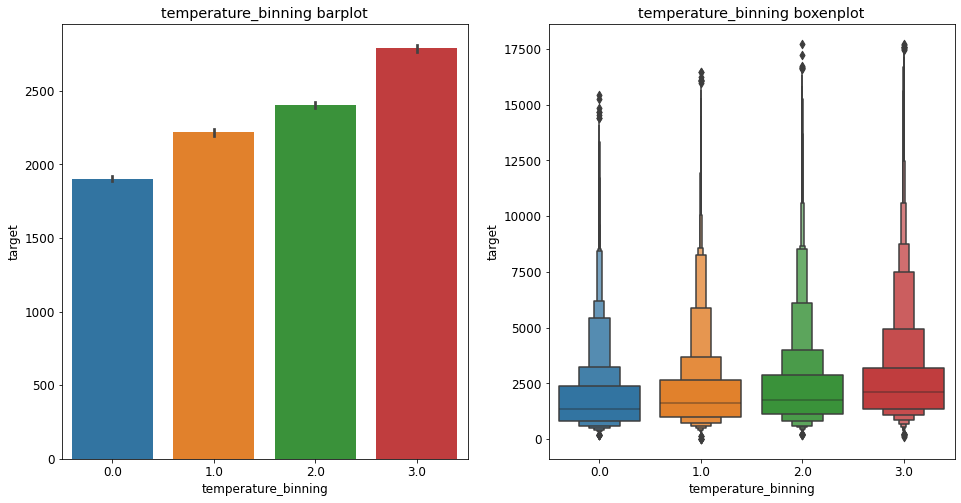

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[0])
ax[0].set_title('temperature_binning barplot')

sns.boxenplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[1])
ax[1].set_title('temperature_binning boxenplot')

- 이상치가 많은것으로 보이고 이상치는 사용 용도인 num에 따라서 다른 것 같다 우리는 num을 target 별로 군집화 하는게 어떨지 생각해 본다.
- 그게 안된다면 target을 포함한 변수들로 건물의 쓰이는 용도를 군집화 해주는 방법도 좋은 것 같다.

## 풍향(Wind speed)

In [27]:
train['Wind speed'].value_counts()

1.1     4241
1.6     3911
1.5     3831
1.2     3811
1.4     3746
        ... 
16.3       1
16.8       1
11.9       1
15.4       1
16.6       1
Name: Wind speed, Length: 155, dtype: int64

<AxesSubplot:xlabel='Wind speed', ylabel='target'>

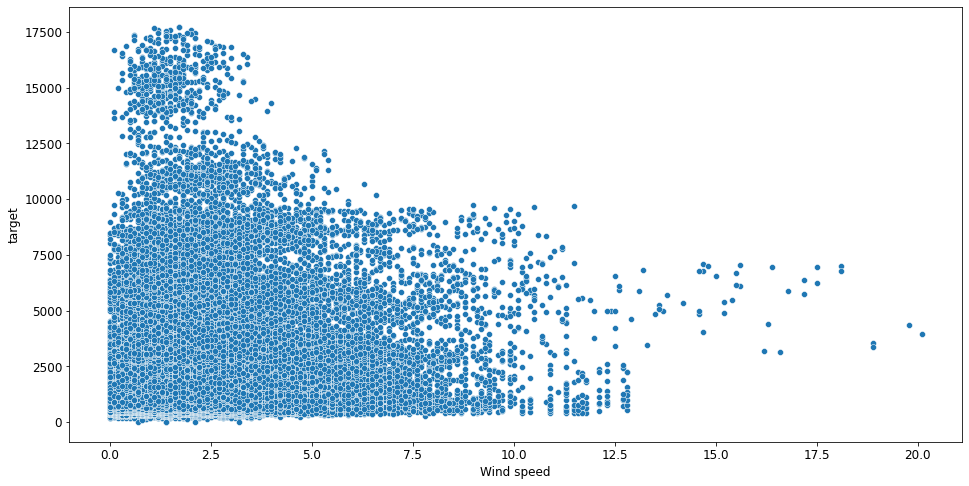

In [28]:
sns.scatterplot(data =train, x = 'Wind speed', y = 'target')

## 습도(Humidity)

In [29]:
train['Humidity'].value_counts

<bound method IndexOpsMixin.value_counts of 0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64>

<AxesSubplot:xlabel='Humidity', ylabel='target'>

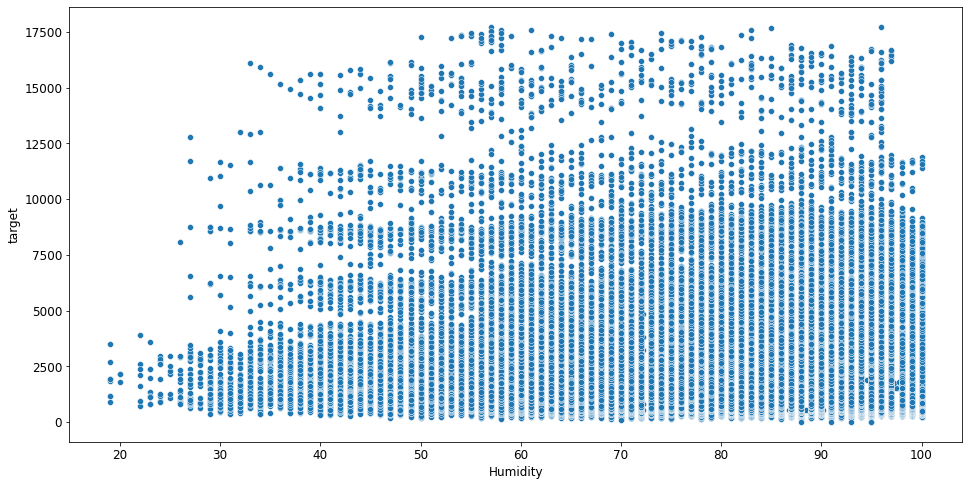

In [30]:
sns.scatterplot(data = train, x = 'Humidity', y = 'target')

## 강수량(Precipitation)

In [31]:
train['Precipitation'].value_counts()

0.0     103473
0.1       2508
0.2       1644
0.3       1171
0.5        830
         ...  
25.1         1
25.2         1
27.9         1
31.0         1
54.6         1
Name: Precipitation, Length: 296, dtype: int64

<AxesSubplot:xlabel='Precipitation', ylabel='target'>

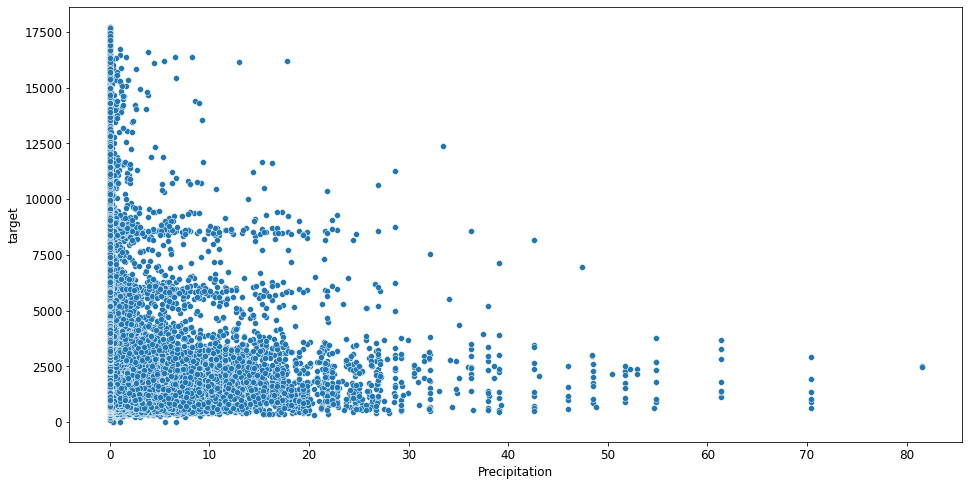

In [32]:
sns.scatterplot(data = train, x = 'Precipitation', y = 'target')

## 일조(sunshine)

In [33]:
train['sunshine'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: sunshine, dtype: int64

<AxesSubplot:xlabel='sunshine', ylabel='target'>

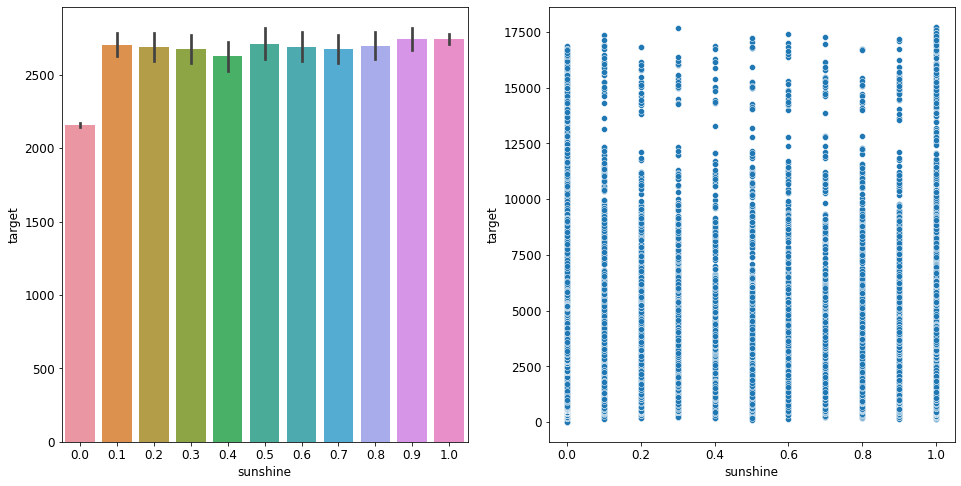

In [34]:
fig, ax = plt.subplots(ncols = 2)
sns.barplot(data = train, x = 'sunshine', y = 'target', ax = ax[0])

sns.scatterplot(data = train, x = 'sunshine', y = 'target', ax = ax[1])

## 비전기냉방설비운영

<AxesSubplot:xlabel='비전기냉방설비운영', ylabel='target'>

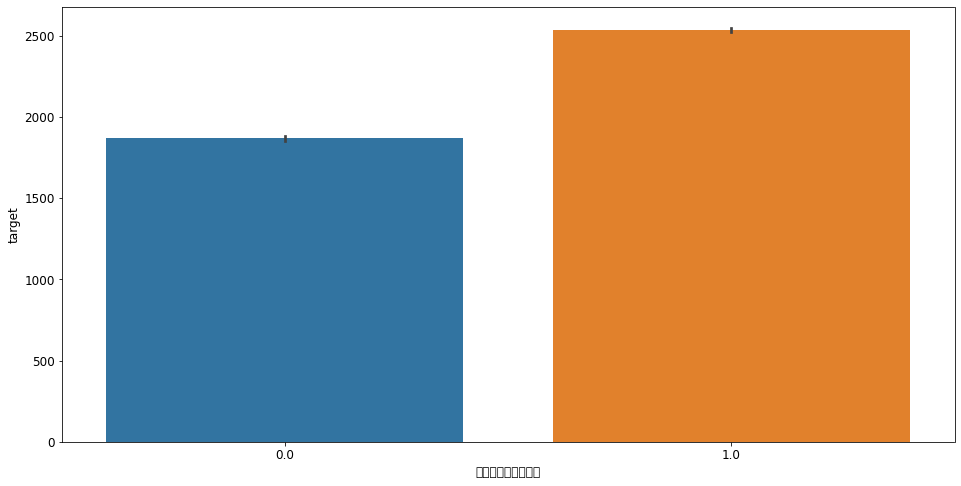

In [35]:
sns.barplot(data = train, x = '비전기냉방설비운영', y = 'target')

In [36]:
# 비전기냉방설비운영을 안하고있다가 하고 있는 곳을 확인했지만 그런 곳은 확인하지 못했다.
비전기냉방설비운영_0=list(train[train['비전기냉방설비운영'] == 0]['num'].unique())
비전기냉방설비운영_1=list(train[train['비전기냉방설비운영'] == 1]['num'].unique())

for i in 비전기냉방설비운영_0:
    비전기냉방설비운영_1.append(i)


len(비전기냉방설비운영_1) == len(train['num'].unique())

True

## 태양광보유

<AxesSubplot:xlabel='태양광보유', ylabel='target'>

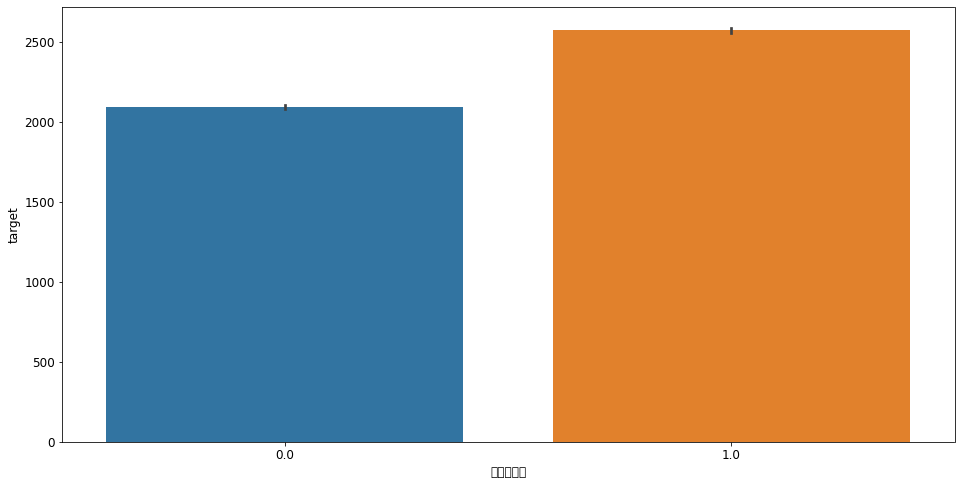

In [37]:
sns.barplot(data = train, x = '태양광보유', y = 'target')

In [38]:
# 태양광을 보유하지 않다가 보유한 건물이 있는지 확인해 보자.
태양광보유_0 = list(train[train['태양광보유'] == 0]['num'].unique())
태양광보유_1 = list(train[train['태양광보유'] == 1]['num'].unique())

for i in 태양광보유_0:
    태양광보유_1.append(i)
    
len(태양광보유_1) == len(train['num'].unique())

True

In [39]:
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 0), 'new_column'] = 0
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 1), 'new_column'] = 1
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 0), 'new_column'] = 2
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 1), 'new_column'] = 3

<AxesSubplot:xlabel='new_column', ylabel='target'>

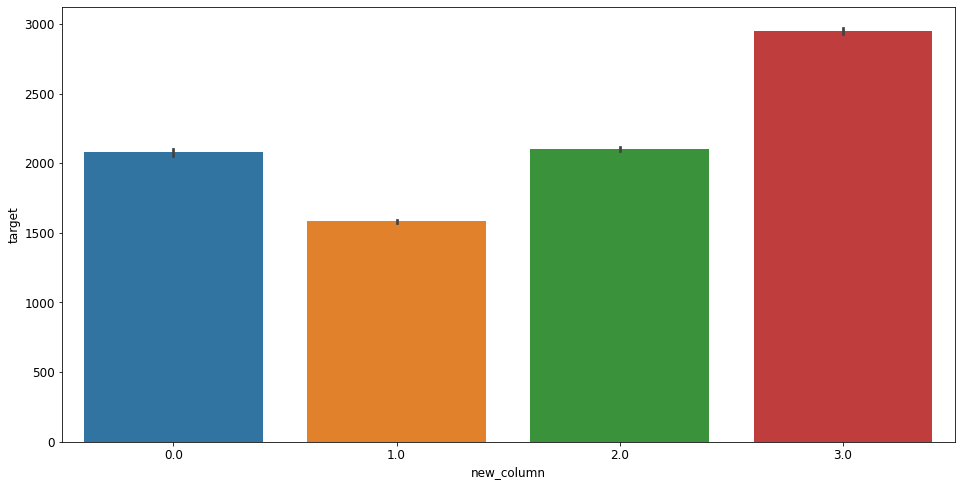

In [40]:
sns.barplot(data = train, x = 'new_column', y = 'target')

## 체감온도 구하기

In [41]:
train['Humidity']

0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64

In [42]:
train['Humidity'].min()

19.0

In [43]:
def winter_temperature(df = None):
    df['Wind speed km/h'] = df['Wind speed'].apply(lambda x: x*3.6)
    def tem(x):
        V = 'Wind speed km/h'
        T = 'Temperatures'
        temperature= 13.12 + (0.6215*x[T]) - 11.37*((x[V])**0.16) + (0.3965*(x[V] **0.16)*x[T])
        return temperature
    temperature = tem(df)
    df['겨울철 체감온도'] = temperature
    df.drop('Wind speed km/h', axis = 1, inplace = True)
    return df


def summer_temperature(df = None):
    
    def tem1(x):
        T = 'Temperatures'
        H = 'Humidity'
        temperature = x[T] + ((x[H] - 50)* 0.1)
        return temperature
    temperature = tem1(df)
    df['여름철 체감온도'] = temperature
    
    return df

In [44]:
# train= winter_temperature(train)
# test = winter_temperature(test)
                                      
train = summer_temperature(train)
test = summer_temperature(test)

습도 50%를 기준으로 10%가 올라가면 플러스 1도, 떨어지면 마이너스 1도로 치고 폭염주의보와 경보도 기온이 아니라 체감온도를 기준으로 발령하기로 했습니다 

In [46]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.scatterplot(data = train, x = '겨울철 체감온도', y = 'target', ax = ax[0])
# ax[0].set_title('winter temperature')

sns.scatterplot(data = train, x = '여름철 체감온도', y = 'target', ax = ax[1])
ax[1].set_title('summer temperature')

Text(0.5, 1.0, 'summer temperature')

## Test EDA

In [47]:
test = date_time(test)
test = weekday(df = test)

In [48]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [49]:
test.isnull().sum()

num                       0
date_time                 0
Temperatures           6720
Wind speed             6720
Humidity               6720
Precipitation          8400
sunshine               6720
비전기냉방설비운영              7784
태양광보유                  8456
temperature_binning    6791
여름철 체감온도               6720
month                     0
day                       0
hour                      0
weekday                   0
dtype: int64

In [50]:
print('3시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Temperatures']) - (len(test['Temperatures'])/3))
print('6시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Humidity']) - len(test['Humidity'])/ 6)
# 해당 결측치의 값과 같다.

3시간마다 데이터가 입력된다면 결측치의 값 : 6720.0
6시간마다 데이터가 입력된다면 결측치의 값 : 8400.0


- 기온, 풍속, 습도. 일조는 3시간마다 데이터가 입력되어 있다.
- 그러나 강수량은 6시간마다 데이터가 입력되어 있기 때문에 결측치도 다르다.
- 그래서 이 데이터를 어떻게 해주어야 할지 고민해 봐야겠다.

In [51]:
# Nan값으로 표시된 것은 전부 비전기냉방설비운영을 하지않는 사람인 것 같다.
test['비전기냉방설비운영'].value_counts()

1.0    2296
Name: 비전기냉방설비운영, dtype: int64

In [52]:
# Nan값으로 표시된 것은 전부 태양광보유를 하지 않은 사람이다.
test['태양광보유'].value_counts()

1.0    1624
Name: 태양광보유, dtype: int64

In [53]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 비전기냉방설비운영
for num in test['num'].unique():
    if len(test[test['num'] == num]['비전기냉방설비운영'].value_counts()) == 1:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 1
    else:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 0

In [54]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 태양광보유
for num in test['num'].unique():
    if len(test[test['num'] == num]['태양광보유'].value_counts()) == 1:
        test.loc[test['num'] == num, '태양광보유'] = 1
    else:
        test.loc[test['num'] == num, '태양광보유'] = 0

In [55]:
print(test['비전기냉방설비운영'].value_counts())
print(test['태양광보유'].value_counts())

1.0    6888
0.0    3192
Name: 비전기냉방설비운영, dtype: int64
0.0    5208
1.0    4872
Name: 태양광보유, dtype: int64


In [56]:
len(test)

10080

In [57]:
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 0), 'new_column'] = 0
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 1), 'new_column'] = 1
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 0), 'new_column'] = 2
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 1), 'new_column'] = 3

## 모델링

In [58]:
dummies = ['num','hour','weekday','new_column','temperature_binning'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
train_data=pd.get_dummies(data = train, columns = dummies)
test_data = pd.get_dummies(data = test, columns = dummies)

drop_columns = ['day','date_time','비전기냉방설비운영','태양광보유','Temperatures']
train_data = train_data.drop(drop_columns, axis = 1)
test_data = test_data.drop(drop_columns, axis = 1)

# month가 object로 들어가 있으므로 int형으로 바꿔준다.
train_data['month'] = train_data['month'].astype('int')
test_data['month'] = test_data['month'].astype('int')

In [59]:
train_data.drop('temperature_binning_0.0', axis = 1 ,inplace = True)

In [60]:
test_data

,Wind speed,Humidity,Precipitation,sunshine,여름철 체감온도,month,num_1,num_2,num_3,num_4,...,hour_23,weekday_0,weekday_1,new_column_0.0,new_column_1.0,new_column_2.0,new_column_3.0,temperature_binning_1.0,temperature_binning_2.0,temperature_binning_3.0
0,1.5,74.0,0.0,0.0,30.2,8,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,NaN,8,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,8,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,1.1,78.0,NaN,0.0,30.1,8,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4,NaN,NaN,NaN,NaN,NaN,8,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,NaN,NaN,NaN,NaN,NaN,8,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10076,NaN,NaN,NaN,NaN,NaN,8,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10077,4.1,68.0,NaN,0.0,29.7,8,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
10078,NaN,NaN,NaN,NaN,NaN,8,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [61]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop('target', axis = 1), train_data['target'], test_size = 0.2, random_state = 42)


# # lightgbm
# lgb=LGBMRegressor()
# lgb.fit(train_data.drop('target', axis = 1), train_data['target'])
# y_pred=lgb.predict(test_data)


# catboost
catboost = CatBoostRegressor()
catboost.fit(train_data.drop('target', axis = 1), train_data['target'])
y_pred=catboost.predict(test_data)


# # xgboost
# xgb = XGBRegressor()
# xgb.fit(train_data.drop('target', axis = 1), train_data['target'])
# y_pred=xgb.predict(test_data)

Learning rate set to 0.091839
0:	learn: 1934.4939315	total: 192ms	remaining: 3m 11s
1:	learn: 1825.4058723	total: 209ms	remaining: 1m 44s
2:	learn: 1730.2408166	total: 241ms	remaining: 1m 20s
3:	learn: 1647.5990346	total: 259ms	remaining: 1m 4s
4:	learn: 1576.5892209	total: 284ms	remaining: 56.5s
5:	learn: 1513.6332242	total: 305ms	remaining: 50.5s
6:	learn: 1457.5902112	total: 338ms	remaining: 48s
7:	learn: 1409.7834918	total: 360ms	remaining: 44.7s
8:	learn: 1368.1195815	total: 382ms	remaining: 42.1s
9:	learn: 1329.1060821	total: 405ms	remaining: 40.1s
10:	learn: 1296.5345610	total: 436ms	remaining: 39.2s
11:	learn: 1265.4399334	total: 462ms	remaining: 38s
12:	learn: 1239.0699594	total: 479ms	remaining: 36.4s
13:	learn: 1214.3265990	total: 501ms	remaining: 35.3s
14:	learn: 1191.4862934	total: 516ms	remaining: 33.9s
15:	learn: 1170.6167989	total: 533ms	remaining: 32.8s
16:	learn: 1151.8136001	total: 546ms	remaining: 31.5s
17:	learn: 1133.4672882	total: 562ms	remaining: 30.7s
18:	learn

162:	learn: 598.6139156	total: 3.6s	remaining: 18.5s
163:	learn: 597.1368757	total: 3.63s	remaining: 18.5s
164:	learn: 595.5323253	total: 3.64s	remaining: 18.4s
165:	learn: 594.4943732	total: 3.66s	remaining: 18.4s
166:	learn: 593.0660479	total: 3.68s	remaining: 18.4s
167:	learn: 592.0692819	total: 3.7s	remaining: 18.3s
168:	learn: 591.0773021	total: 3.73s	remaining: 18.3s
169:	learn: 590.1785805	total: 3.74s	remaining: 18.3s
170:	learn: 588.8001773	total: 3.77s	remaining: 18.3s
171:	learn: 587.1409066	total: 3.79s	remaining: 18.3s
172:	learn: 585.5986990	total: 3.82s	remaining: 18.3s
173:	learn: 584.7480081	total: 3.84s	remaining: 18.3s
174:	learn: 583.4262781	total: 3.87s	remaining: 18.2s
175:	learn: 582.0345047	total: 3.88s	remaining: 18.2s
176:	learn: 581.2022950	total: 3.9s	remaining: 18.1s
177:	learn: 579.6687315	total: 3.91s	remaining: 18.1s
178:	learn: 578.7799452	total: 3.92s	remaining: 18s
179:	learn: 578.1026897	total: 3.94s	remaining: 18s
180:	learn: 576.5636153	total: 3.97

317:	learn: 467.5841794	total: 6.96s	remaining: 14.9s
318:	learn: 466.8438551	total: 6.99s	remaining: 14.9s
319:	learn: 466.2975218	total: 7s	remaining: 14.9s
320:	learn: 465.8323125	total: 7.02s	remaining: 14.9s
321:	learn: 465.3161879	total: 7.05s	remaining: 14.8s
322:	learn: 464.6464956	total: 7.08s	remaining: 14.8s
323:	learn: 463.9859660	total: 7.11s	remaining: 14.8s
324:	learn: 463.5695405	total: 7.13s	remaining: 14.8s
325:	learn: 463.0553272	total: 7.16s	remaining: 14.8s
326:	learn: 462.2543564	total: 7.19s	remaining: 14.8s
327:	learn: 461.8312989	total: 7.2s	remaining: 14.8s
328:	learn: 461.1902330	total: 7.22s	remaining: 14.7s
329:	learn: 460.5525880	total: 7.24s	remaining: 14.7s
330:	learn: 460.2322674	total: 7.26s	remaining: 14.7s
331:	learn: 459.8288011	total: 7.28s	remaining: 14.6s
332:	learn: 459.3716283	total: 7.3s	remaining: 14.6s
333:	learn: 458.8740894	total: 7.33s	remaining: 14.6s
334:	learn: 458.1732400	total: 7.35s	remaining: 14.6s
335:	learn: 457.7272943	total: 7.

473:	learn: 404.1623074	total: 10.6s	remaining: 11.8s
474:	learn: 403.7640112	total: 10.6s	remaining: 11.7s
475:	learn: 403.3396434	total: 10.6s	remaining: 11.7s
476:	learn: 402.9590829	total: 10.7s	remaining: 11.7s
477:	learn: 402.6960422	total: 10.7s	remaining: 11.7s
478:	learn: 402.5403652	total: 10.7s	remaining: 11.7s
479:	learn: 402.3223438	total: 10.8s	remaining: 11.7s
480:	learn: 401.9583181	total: 10.8s	remaining: 11.6s
481:	learn: 401.7534951	total: 10.8s	remaining: 11.6s
482:	learn: 401.4870011	total: 10.8s	remaining: 11.6s
483:	learn: 401.1348592	total: 10.8s	remaining: 11.6s
484:	learn: 400.8089045	total: 10.9s	remaining: 11.6s
485:	learn: 400.6508796	total: 10.9s	remaining: 11.5s
486:	learn: 400.3003214	total: 10.9s	remaining: 11.5s
487:	learn: 400.0202540	total: 10.9s	remaining: 11.5s
488:	learn: 399.7353354	total: 11s	remaining: 11.5s
489:	learn: 399.3625075	total: 11s	remaining: 11.4s
490:	learn: 398.9993587	total: 11s	remaining: 11.4s
491:	learn: 398.6751841	total: 11.

626:	learn: 365.7972335	total: 14.4s	remaining: 8.57s
627:	learn: 365.6533289	total: 14.4s	remaining: 8.55s
628:	learn: 365.5087114	total: 14.5s	remaining: 8.53s
629:	learn: 365.3410486	total: 14.5s	remaining: 8.51s
630:	learn: 365.1385747	total: 14.5s	remaining: 8.49s
631:	learn: 364.9902108	total: 14.5s	remaining: 8.46s
632:	learn: 364.8175127	total: 14.6s	remaining: 8.45s
633:	learn: 364.5472194	total: 14.6s	remaining: 8.43s
634:	learn: 364.4526179	total: 14.6s	remaining: 8.41s
635:	learn: 364.1834577	total: 14.6s	remaining: 8.38s
636:	learn: 364.0535740	total: 14.7s	remaining: 8.36s
637:	learn: 363.8249837	total: 14.7s	remaining: 8.33s
638:	learn: 363.5825044	total: 14.7s	remaining: 8.31s
639:	learn: 363.3273606	total: 14.7s	remaining: 8.29s
640:	learn: 363.1859535	total: 14.7s	remaining: 8.26s
641:	learn: 363.0177802	total: 14.8s	remaining: 8.24s
642:	learn: 362.7473506	total: 14.8s	remaining: 8.21s
643:	learn: 362.5427440	total: 14.8s	remaining: 8.19s
644:	learn: 362.3643472	tota

784:	learn: 338.3627532	total: 17.7s	remaining: 4.85s
785:	learn: 338.2552763	total: 17.7s	remaining: 4.83s
786:	learn: 338.0939498	total: 17.8s	remaining: 4.81s
787:	learn: 337.9575567	total: 17.8s	remaining: 4.78s
788:	learn: 337.8444042	total: 17.8s	remaining: 4.76s
789:	learn: 337.7215338	total: 17.8s	remaining: 4.73s
790:	learn: 337.6277076	total: 17.8s	remaining: 4.71s
791:	learn: 337.5329795	total: 17.8s	remaining: 4.68s
792:	learn: 337.3417153	total: 17.9s	remaining: 4.66s
793:	learn: 337.2070658	total: 17.9s	remaining: 4.64s
794:	learn: 337.1034757	total: 17.9s	remaining: 4.61s
795:	learn: 337.0081297	total: 17.9s	remaining: 4.59s
796:	learn: 336.8749928	total: 17.9s	remaining: 4.56s
797:	learn: 336.6927005	total: 17.9s	remaining: 4.54s
798:	learn: 336.5787525	total: 18s	remaining: 4.52s
799:	learn: 336.4813765	total: 18s	remaining: 4.49s
800:	learn: 336.3330439	total: 18s	remaining: 4.47s
801:	learn: 336.2543476	total: 18s	remaining: 4.45s
802:	learn: 336.1423096	total: 18s	r

947:	learn: 318.7583622	total: 20.3s	remaining: 1.11s
948:	learn: 318.6522819	total: 20.4s	remaining: 1.09s
949:	learn: 318.5577811	total: 20.4s	remaining: 1.07s
950:	learn: 318.4972231	total: 20.4s	remaining: 1.05s
951:	learn: 318.3434683	total: 20.4s	remaining: 1.03s
952:	learn: 318.2084338	total: 20.4s	remaining: 1.01s
953:	learn: 318.0116426	total: 20.4s	remaining: 985ms
954:	learn: 317.9191377	total: 20.4s	remaining: 963ms
955:	learn: 317.8218176	total: 20.5s	remaining: 941ms
956:	learn: 317.7292783	total: 20.5s	remaining: 920ms
957:	learn: 317.6482488	total: 20.5s	remaining: 898ms
958:	learn: 317.5369625	total: 20.5s	remaining: 876ms
959:	learn: 317.4376162	total: 20.5s	remaining: 855ms
960:	learn: 317.3179977	total: 20.5s	remaining: 833ms
961:	learn: 317.2379945	total: 20.6s	remaining: 812ms
962:	learn: 317.0715494	total: 20.6s	remaining: 791ms
963:	learn: 316.9801205	total: 20.6s	remaining: 769ms
964:	learn: 316.8574562	total: 20.6s	remaining: 747ms
965:	learn: 316.7699302	tota

In [62]:
y_pred

array([8418.19434473, 8106.24279219, 8083.34983124, ..., 3559.60957061,
       2972.63230379, 2854.93246435])

In [63]:
submission['answer'] = y_pred

In [64]:
submission.isnull().sum()

num_date_time    0
answer           0
dtype: int64

In [65]:
submission.to_csv('C:/Users/lg/전력사용량 예측 AI 경진대회/submission.csv',index= False)